# Introduction to Neural Networks 
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step. 

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5016892181237539, accuracy: 87.59791666666666
Epoch 0: val. loss: 0.49338222057261366, val. accuracy: 87.64166666666667
Epoch 1: training loss: 0.42155136581261954, accuracy: 89.02708333333334
Epoch 1: val. loss: 0.41174687635391316, val. accuracy: 88.94999999999999
Epoch 2: training loss: 0.3876514703035355, accuracy: 89.65625
Epoch 2: val. loss: 0.37734148318463184, val. accuracy: 89.56666666666668
Epoch 3: training loss: 0.3677122631072998, accuracy: 90.075
Epoch 3: val. loss: 0.3572775349020958, val. accuracy: 89.90833333333333
Epoch 4: training loss: 0.3541419803301493, accuracy: 90.4125
Epoch 4: val. loss: 0.3437617359326241, val. accuracy: 90.21666666666667
CPU times: user 1min 51s, sys: 341 ms, total: 1min 52s
Wall time: 37.2 s


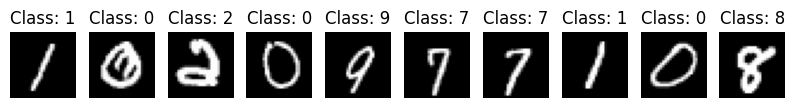

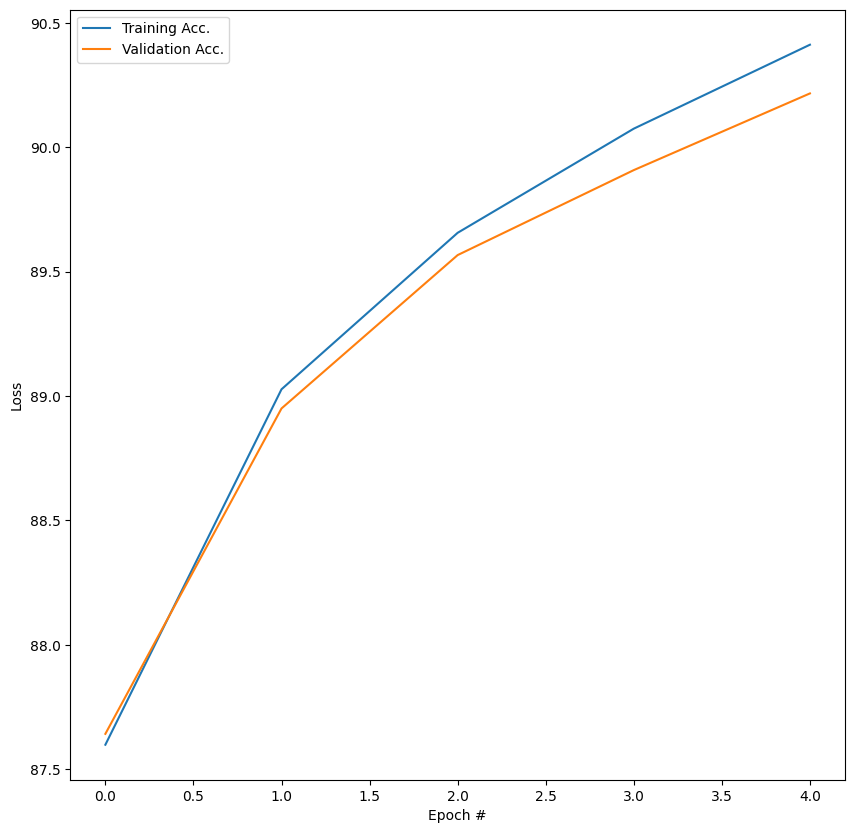

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()

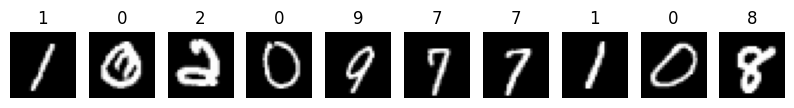

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())
    
plt.show()

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#create dataloader for test data
# The dataloader makes our dataset iterable 
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3324, test accuracy: 90.75%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1
    
    plt.show()

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


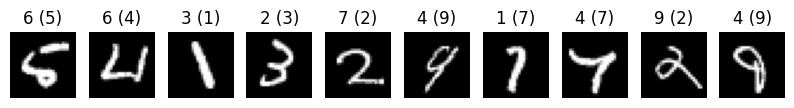

In [17]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7596894439061482, accuracy: 79.03750000000001
Epoch 0: val. loss: 0.758942242632521, val. accuracy: 78.60833333333333
Epoch 1: training loss: 0.40538066935539246, accuracy: 88.61458333333333
Epoch 1: val. loss: 0.40035878470603453, val. accuracy: 88.44166666666666
Epoch 2: training loss: 0.3037498760223389, accuracy: 91.43541666666667
Epoch 2: val. loss: 0.29829216875294423, val. accuracy: 91.175
Epoch 3: training loss: 0.25252492396036785, accuracy: 92.7375
Epoch 3: val. loss: 0.24964079466906, val. accuracy: 92.45
Epoch 4: training loss: 0.2093929781317711, accuracy: 93.975
Epoch 4: val. loss: 0.21146170699850042, val. accuracy: 93.59166666666667
CPU times: user 1min 55s, sys: 307 ms, total: 1min 56s
Wall time: 38.3 s


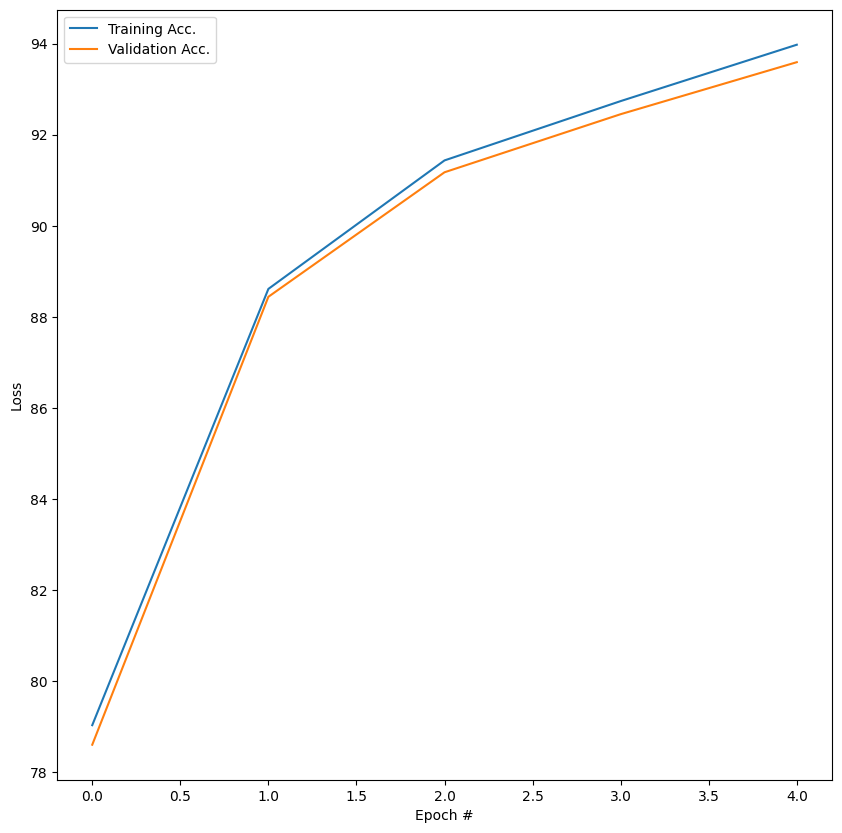

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


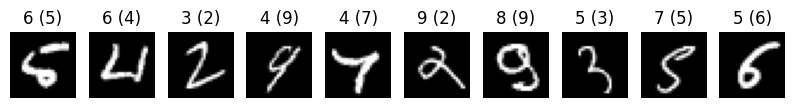

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

In [105]:
# Different batch sizes to iterate over
batch_sizes = [128, 256, 512]
dataloaders = []

for batch_size in batch_sizes:
    # Train, val, test dataloaders
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    dataloaders.append((train_dataloader, val_dataloader, test_dataloader))

In [106]:
# Using ReLU
class ReLUClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [107]:
# Using Leaky ReLU
class LeakyReLUClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [108]:
# Using SiLU
class SiLUClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [109]:
# Reset weights between iterations
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

In [110]:
# Adjustment to train_one_epoch
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    correct = 0
    
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    avg_loss = total_loss / num_batches
    accuracy = 100 * correct / size
    
    return avg_loss, accuracy

In [111]:
# Adjustment to eval
def evaluate(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [112]:
# Function to train each NN
def train_and_eval_nn(model, train_dataloader, val_dataloader, test_dataloader, lr, epochs=5):
    model.apply(weight_reset)
    
    # Reset random seeds
    torch.manual_seed(9)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    start = time.perf_counter()
    train_acc_all = []
    val_acc_all = []
    
    for epoch in range(epochs):
        avg_loss, train_acc = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        train_acc_all.append(train_acc)
        print(f"Epoch {epoch}: training loss: {avg_loss:.4f}, accuracy: {train_acc:.2f}%")
        
        val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {epoch}: val. loss: {val_loss:.4f}, val. accuracy: {val_acc:.2f}%")
        
    train_time = time.perf_counter() - start
    print(f'Training time for {epochs} epochs: {train_time:.2f} seconds')
        
    acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
    print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))
    
    return (train_acc_all, val_acc_all, acc_test, loss_test, train_time)

In [113]:
# Instantiate models
relu_model = ReLUClassifier()
leakyrelu_model = LeakyReLUClassifier()
silu_model = SiLUClassifier()

In [114]:
# List of learning rates to iterate over
learning_rates = [0.01, 0.05, 0.1]

In [115]:
# List of activation function models to iterate over
models = [relu_model, leakyrelu_model, silu_model,]
activation_function_names = ['ReLU', 'LeakyReLU', 'SiLU',]

In [116]:
# Loop over batch_size, learning rate, activation functions
epochs = 10
eval_metrics = []
for dataloader_set in dataloaders:
    batch_size_metrics = []
    
    # Extract dataloaders
    train_dataloader, val_dataloader, test_dataloader = dataloader_set
    
    for learning_rate in learning_rates:
        lr_metrics = []
        for activation_function in models:
            model_metric = train_and_eval_nn(activation_function, train_dataloader, val_dataloader, test_dataloader, learning_rate, epochs)
            lr_metrics.append(model_metric)
        batch_size_metrics.append(lr_metrics)
    eval_metrics.append(batch_size_metrics)

Epoch 0: training loss: 2.2953, accuracy: 15.47%
Epoch 0: val. loss: 2.2801, val. accuracy: 24.88%
Epoch 1: training loss: 2.2591, accuracy: 24.40%
Epoch 1: val. loss: 2.2131, val. accuracy: 39.02%
Epoch 2: training loss: 2.1190, accuracy: 35.77%
Epoch 2: val. loss: 1.8818, val. accuracy: 49.17%
Epoch 3: training loss: 1.6796, accuracy: 44.70%
Epoch 3: val. loss: 1.2692, val. accuracy: 70.57%
Epoch 4: training loss: 1.2675, accuracy: 57.59%
Epoch 4: val. loss: 0.8856, val. accuracy: 78.31%
Epoch 5: training loss: 1.0135, accuracy: 66.38%
Epoch 5: val. loss: 0.6981, val. accuracy: 81.29%
Epoch 6: training loss: 0.8735, accuracy: 72.00%
Epoch 6: val. loss: 0.5996, val. accuracy: 83.65%
Epoch 7: training loss: 0.7771, accuracy: 75.49%
Epoch 7: val. loss: 0.5236, val. accuracy: 85.39%
Epoch 8: training loss: 0.7031, accuracy: 78.26%
Epoch 8: val. loss: 0.4704, val. accuracy: 86.82%
Epoch 9: training loss: 0.6448, accuracy: 80.48%
Epoch 9: val. loss: 0.4254, val. accuracy: 87.83%
Training t

In [117]:
# Break metrics and accuracies into lists
metrics_dict_list = []
accuracies_list = []

for i in range(len(eval_metrics)):
    batch_size = eval_metrics[i]
    for j in range(len(batch_size)):
        learning_rate = batch_size[j]
        for k in range(len(learning_rate)):
            activation_fxn = learning_rate[k]
            train_acc_all, val_acc_all, acc_test, loss_test, train_time = activation_fxn
            metrics = {
                'batch_size': batch_sizes[i],
                'learning_rate': learning_rates[j],
                'activation_function': activation_function_names[k],
                'test_accuracy': acc_test,
                'test_loss': loss_test,
                'train_time': train_time,
            }
            metrics_dict_list.append(metrics)
            
            accuracies = batch_sizes[i], learning_rates[j], activation_function_names[k], train_acc_all, val_acc_all
            accuracies_list.append(accuracies)

In [121]:
import polars as pl

pl.Config.set_tbl_rows(-1)

# Table for all the metrics sorted by test accuracy
metrics_df = pl.DataFrame(metrics_dict_list)
metrics_df.sort('test_accuracy', descending=True)

batch_size,learning_rate,activation_function,test_accuracy,test_loss,train_time
i64,f64,str,f64,f64,f64
128,0.1,"""LeakyReLU""",96.01,0.129963,46.181792
128,0.1,"""ReLU""",95.91,0.132535,47.368297
128,0.1,"""SiLU""",95.87,0.131026,45.085971
128,0.05,"""ReLU""",95.12,0.158097,42.184208
128,0.05,"""LeakyReLU""",95.06,0.159738,42.895922
256,0.1,"""ReLU""",94.78,0.167566,42.31773
256,0.1,"""LeakyReLU""",94.75,0.168032,43.716408
128,0.05,"""SiLU""",93.94,0.200486,42.419293
256,0.1,"""SiLU""",93.8,0.19939,41.269364


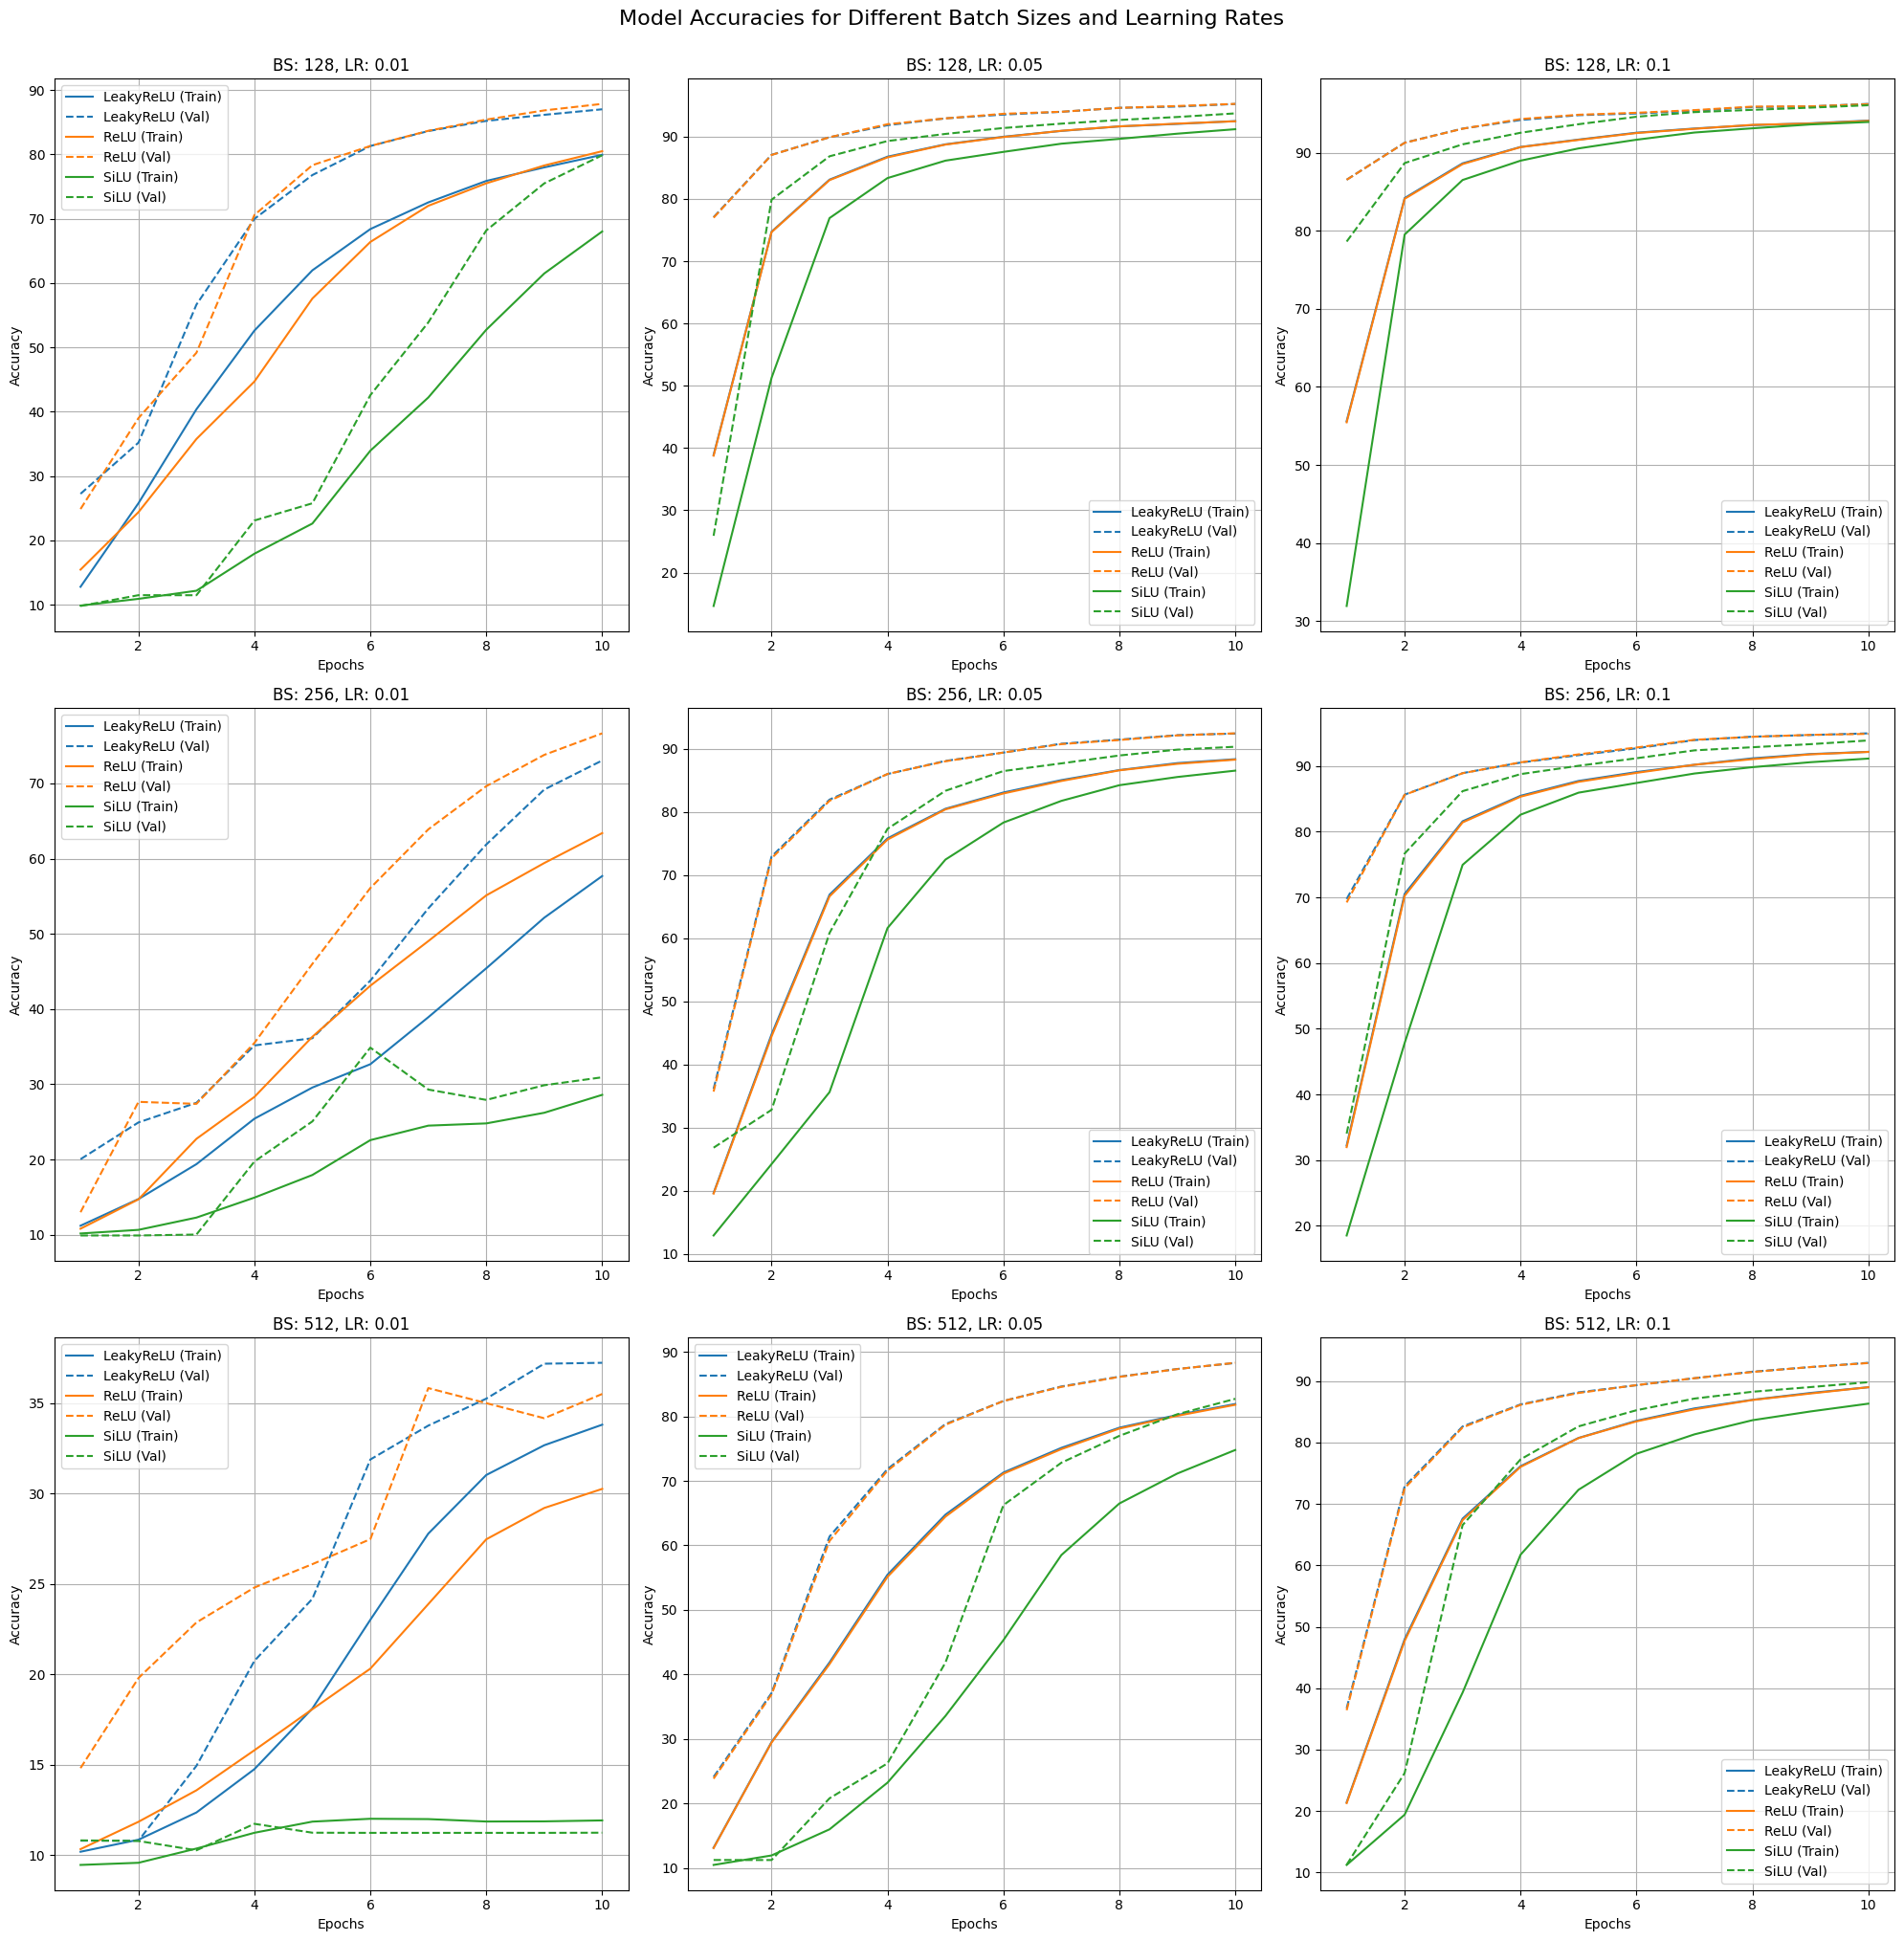

In [143]:
# Plot train/val accuracies
batch_sizes = sorted(set(acc[0] for acc in accuracies_list))
learning_rates = sorted(set(acc[1] for acc in accuracies_list))
activation_functions = sorted(set(acc[2] for acc in accuracies_list))

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 22))
fig.suptitle('Model Accuracies for Different Batch Sizes and Learning Rates', fontsize=16, y=0.95)

# Flatten the 2D array of subplots for easier iteration
axs_flat = axs.flatten()

for idx, (bs, lr) in enumerate([(b, l) for b in batch_sizes[:3] for l in learning_rates[:3]]):
    ax = axs_flat[idx]
    
    for i, activation in enumerate(activation_functions):
        matching = [acc for acc in accuracies_list if acc[0] == bs and acc[1] == lr and acc[2] == activation]
        if matching:
            epochs = range(1, len(matching[0][3]) + 1)
            color = f'C{i}'
            ax.plot(epochs, matching[0][3], label=f'{activation} (Train)', color=color, linestyle='-')
            ax.plot(epochs, matching[0][4], label=f'{activation} (Val)', color=color, linestyle='--')
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'BS: {bs}, LR: {lr}')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Learning Rate Scheduler

My understanding of a learning rate scheduler is that it decreases learning rate over time to allow larger changes with the gradient on earlier epochs and then by reducing learning rate, the changes become smaller, helping convergence. Otherwise, having the same learning rate throughout training may cause the model to never really reach the minima and just "bounce around" it, since the step-size is too large.

A large initial learning rate increases the chances of escaping local minima and will help loss decrease faster initially. The adjustments to the weights become more fine-tuned as learning rate decreases.

Common Scheduler Types:

- Step Decay: Reduces the learning rate by a factor every few epochs.
- Exponential Decay: Continuously decreases the learning rate exponentially.
- Cosine Annealing: Decreases the learning rate following a cosine curve.
- Cyclic Learning Rates: Oscillates the learning rate between boundaries.